In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams, concatenate
from pandas import concat
from keras.models import load_model

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

warnings.simplefilter('ignore')

get_ipython().run_line_magic('matplotlib', 'inline')

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# 所有绘图使用svg格式
# get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# 增加图片大小
rcParams['figure.figsize'] = 8, 6

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# 处理数据，最终要让数据的格式都是500个销售列和每天一行，如果不这么做，怎么预测到每个店，每个商品的销售呢？

df_train.head()

df_train.index = pd.to_datetime(df_train['date'])
df_train.drop('date', axis=1, inplace=True)
df_test.index = pd.to_datetime(df_test['date'])
df_test.drop('date', axis=1, inplace=True)

from itertools import product, starmap


def storeitems():
    return product(range(1, 51), range(1, 11))


def storeitems_column_names():
    return list(starmap(lambda i, s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

df_train = sales_by_storeitem(df_train)
# 对于测试集，我们只是用0填充y值
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

# 数据组合起来为模型做准备，然后将其分解为训练集和测试集。

# 确保所有列名都是相同的，并且顺序相同
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])
df_total.info()

df_total.head()

# ### 特征工程
# 使用One-hot编码日，一周和一个月，以确保网络识别数据的季节性。

weekday_df = pd.get_dummies(df_total.index.weekday, prefix='weekday')
weekday_df.index = df_total.index

month_df = pd.get_dummies(df_total.index.month, prefix='month')
month_df.index = df_total.index

df_total = pd.concat([weekday_df, month_df, df_total], axis=1)

assert df_total.isna().any().any() == False


# 如果是单步预测我们还希望将前一天的sales追加到每一行，然后将其用作输入数据。
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days))


def shift_series_in_df(df, series_names=[], days_delta=90):
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret


def stack_shifted_sales(df, days_deltas=[1, 90, 360]):
    names = storeitems_column_names()
    dfs = [df.copy()]
    for delta in days_deltas:
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, sort=False, copy=False)

df_total = stack_shifted_sales(df_total, days_deltas=[1])
df_total.dropna(inplace=True)


# 我们需要确保堆叠和非堆叠后的数据的销售列以相同的顺序排列。通过对名称(作为字符串)进行排序来实现这一点

sales_cols = [col for col in df_total.columns if '_sales' in col and '_sales_' not in col]
stacked_sales_cols = [col for col in df_total.columns if '_sales_' in col]
other_cols = [col for col in df_total.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]

sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

df_total = df_total.reindex(columns=new_cols)

df_total.head()

assert df_total.isna().any().any() == False

# ### 数据的归一化

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
df_total[cols_to_scale] = scaled_cols

# ### 设置一下训练集和测试集，这个测试集是真正的测试集

df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

# ## 训练模型
# 首先，我们需要将训练数据分离为输入向量和目标向量，并将部分训练数据分离为模型的验证数据。
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

# 使用2019年第一季度进行验证
X_valid, y_valid = X_valid.head(90), y_valid.head(90)

# 对于Keras，需要对输入值进行进一步的转换，才能够输入到模型中
X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1915 entries, 2015-01-01 to 2020-03-31
Columns: 501 entries, item_1_store_1_sales to is_test
dtypes: bool(1), float64(500)
memory usage: 7.3 MB


In [2]:
basic_model = load_model('basic_model.h5')

In [3]:
y_predict = basic_model.predict(X_valid_vals)
print(X_valid_vals.shape[0], X_valid_vals.shape[2])
X_valid_vals = X_valid_vals.reshape((X_valid_vals.shape[0], X_valid_vals.shape[2]))

90 519


In [4]:
print(X_valid_vals)

[[0.56410256 0.48091603 0.49142857 ... 0.         0.         0.        ]
 [0.50641026 0.40458015 0.50857143 ... 0.         0.         0.        ]
 [0.3525641  0.38931298 0.25142857 ... 0.         0.         0.        ]
 ...
 [0.44871795 0.52671756 0.55428571 ... 0.         0.         0.        ]
 [0.44871795 0.52671756 0.60571429 ... 0.         0.         0.        ]
 [0.53846154 0.45801527 0.51428571 ... 0.         0.         0.        ]]


In [6]:
print(X_valid_vals[:, :6])

[[0.56410256 0.48091603 0.49142857 0.44303797 0.43506494 0.39130435]
 [0.50641026 0.40458015 0.50857143 0.44303797 0.48701299 0.54782609]
 [0.3525641  0.38931298 0.25142857 0.36075949 0.27922078 0.25217391]
 [0.33974359 0.40458015 0.29714286 0.36075949 0.36363636 0.4       ]
 [0.42307692 0.35114504 0.37714286 0.35443038 0.36363636 0.4173913 ]
 [0.41025641 0.35114504 0.49714286 0.37974684 0.38961039 0.37391304]
 [0.40384615 0.40458015 0.41714286 0.43037975 0.42207792 0.50434783]
 [0.51282051 0.46564885 0.53142857 0.46835443 0.49350649 0.49565217]
 [0.53846154 0.48854962 0.50285714 0.39873418 0.51298701 0.42608696]
 [0.32692308 0.27480916 0.29142857 0.28481013 0.31168831 0.27826087]
 [0.37179487 0.40458015 0.49142857 0.43037975 0.33116883 0.30434783]
 [0.34615385 0.33587786 0.37714286 0.44303797 0.2987013  0.26956522]
 [0.40384615 0.39694656 0.4        0.32911392 0.40909091 0.39130435]
 [0.44871795 0.52671756 0.48       0.55696203 0.37662338 0.34782609]
 [0.3974359  0.52671756 0.53142857

In [22]:
inv_y_test = concatenate((X_valid_vals[:,:-18], y_predict), axis=1)

In [20]:
print(inv_y_test)

[[0.56410256 0.48091603 0.49142857 ... 0.47543949 0.46941647 0.50398088]
 [0.50641026 0.40458015 0.50857143 ... 0.40443715 0.40328777 0.4313767 ]
 [0.3525641  0.38931298 0.25142857 ... 0.32905033 0.33587399 0.35916874]
 ...
 [0.44871795 0.52671756 0.55428571 ... 0.44331443 0.44181055 0.46548244]
 [0.44871795 0.52671756 0.60571429 ... 0.44903526 0.4413285  0.4723264 ]
 [0.53846154 0.45801527 0.51428571 ... 0.49182582 0.49109378 0.51863217]]


In [23]:
inv_y_test = scaler.inverse_transform(inv_y_test)

In [66]:
print(inv_y_test)

[[ 0.56410256 75.02290076 64.37714286 ... 37.08428013 62.90180689
  55.43789625]
 [ 0.50641026 63.11450382 66.62285714 ... 31.54609805 54.04056096
  47.45143652]
 [ 0.3525641  60.73282443 32.93714286 ... 25.66592592 45.00711483
  39.50856119]
 ...
 [ 0.44871795 82.16793893 72.61142857 ... 34.57852578 59.20261347
  51.20306879]
 [ 0.44871795 82.16793893 79.34857143 ... 35.02475005 59.13801843
  51.95590377]
 [ 0.53846154 71.45038168 67.37142857 ... 38.36241388 65.80656713
  57.04953909]]


In [68]:
inv_y_predict = inv_y_test[:, -1]
print(len(inv_y_predict))

90


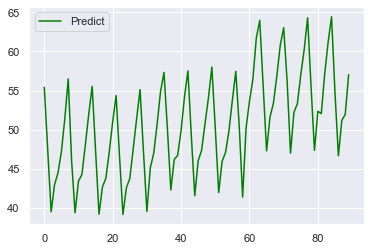

In [34]:
# plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.legend()
plt.show()

In [65]:
print(inv_y_test[:, 1:])

[[75.02290076 64.37714286 77.53164557 ... 37.08428013 62.90180689
  55.43789625]
 [63.11450382 66.62285714 77.53164557 ... 31.54609805 54.04056096
  47.45143652]
 [60.73282443 32.93714286 63.13291139 ... 25.66592592 45.00711483
  39.50856119]
 ...
 [82.16793893 72.61142857 98.57594937 ... 34.57852578 59.20261347
  51.20306879]
 [82.16793893 79.34857143 88.60759494 ... 35.02475005 59.13801843
  51.95590377]
 [71.45038168 67.37142857 79.74683544 ... 38.36241388 65.80656713
  57.04953909]]


In [62]:
print(len(y_valid))

90


In [63]:
print(y_valid.values)

[[0.50641026 0.40458015 0.50857143 ... 0.28205128 0.34328358 0.40909091]
 [0.3525641  0.38931298 0.25142857 ... 0.29487179 0.31343284 0.28181818]
 [0.33974359 0.40458015 0.29714286 ... 0.32051282 0.29104478 0.39090909]
 ...
 [0.44871795 0.52671756 0.60571429 ... 0.46153846 0.52238806 0.47272727]
 [0.53846154 0.45801527 0.51428571 ... 0.41025641 0.50746269 0.5       ]
 [0.46794872 0.53435115 0.6        ... 0.5        0.45522388 0.61818182]]


In [42]:
inv_y_train = concatenate((X_valid_vals[:,:-18], y_valid.values), axis=1)

In [43]:
inv_y_train = scaler.inverse_transform(inv_y_train)

In [44]:
print(inv_y_train)

[[ 0.56410256 75.02290076 64.37714286 ... 22.         46.
  45.        ]
 [ 0.50641026 63.11450382 66.62285714 ... 23.         42.
  31.        ]
 [ 0.3525641  60.73282443 32.93714286 ... 25.         39.
  43.        ]
 ...
 [ 0.44871795 82.16793893 72.61142857 ... 36.         70.
  52.        ]
 [ 0.44871795 82.16793893 79.34857143 ... 32.         68.
  55.        ]
 [ 0.53846154 71.45038168 67.37142857 ... 39.         61.
  68.        ]]


In [57]:
inv_y = inv_y_train[:, -1]

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


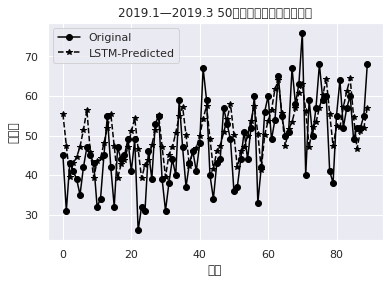

In [98]:
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.plot(inv_y, marker='o', color='black',label='Original')
plt.plot(inv_y_predict, linestyle='--', marker='*', color='black',label='LSTM-Predicted')
plt.xlabel('日期')
plt.ylabel('销售量')
plt.title('2019.1—2019.3 50号商品的销售额预测对比')
plt.legend()
plt.savefig("test.png", dpi=750, bbox_inches = "tight")
plt.show()

In [58]:
print(inv_y)

[45. 31. 43. 41. 39. 35. 42. 47. 45. 43. 32. 34. 45. 55. 42. 32. 47. 44.
 45. 49. 41. 49. 26. 32. 31. 46. 39. 53. 55. 39. 31. 38. 44. 40. 59. 47.
 37. 43. 46. 41. 48. 67. 59. 40. 34. 43. 44. 57. 53. 49. 36. 37. 44. 51.
 44. 52. 60. 33. 42. 56. 60. 49. 54. 65. 55. 50. 51. 67. 58. 63. 76. 40.
 59. 50. 57. 68. 59. 60. 41. 38. 55. 64. 52. 57. 60. 49. 52. 52. 55. 68.]


In [67]:
print(len(inv_y))

90


<Figure size 432x288 with 0 Axes>